# Trabalho prático da disciplina de aprendizado de máquina 2020-01
## Instituto de computação da Universidade Federal Fluminense
### Professora: Flávia Bernardini
### Alunos: João Ricardo Weissmann Santos e Bruna Toledo

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, 
                                   scoring=metrica, cv=n_folds, n_jobs=1, refit=list(metrica.keys())[0])
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df]

In [36]:
for i, _ in enumerate(dfs):
    dataset = dataset.merge(dfs[i].copy(), how='left', on='Country', copy=False)

In [37]:
dataset.shape

(170, 101)

## Analisando o dado

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Columns: 101 entries, Country to Vegetables_quantity
dtypes: float64(98), object(3)
memory usage: 135.5+ KB


In [39]:
dataset.dtypes.value_counts()

float64    98
object      3
dtype: int64

In [40]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [41]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [42]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",...,Pulses_quantity,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,0.001035,20.695714,4.138451,0.000450,...,0.537131,0.091011,5.335371,0.201946,0.095846,2.799115,0.117474,37.814834,0.851554,6.085912
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,0.009569,8.002713,3.287462,0.004039,...,0.601111,0.121898,5.571355,0.189239,0.379936,1.545951,0.146143,5.852943,0.445335,3.560148
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,5.018200,0.026200,0.000000,...,0.000000,0.000000,0.679600,0.004200,0.000000,0.366600,0.000000,23.113200,0.091500,0.857000
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.000000,14.885800,1.674225,0.000000,...,0.129650,0.016500,2.023825,0.083325,0.000000,1.721025,0.020750,33.552775,0.507700,3.616500
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,0.000000,20.943050,3.312350,0.000000,...,0.300800,0.042550,3.108650,0.159450,0.000000,2.601650,0.079950,37.900700,0.774450,5.028100
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,0.000000,26.866950,6.227575,0.000000,...,0.734900,0.123150,5.745875,0.261800,0.000000,3.782150,0.148650,42.762775,1.070900,7.801650
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,0.097600,36.901800,14.937300,0.051100,...,3.483800,0.662600,27.712800,1.282300,3.067700,9.725900,0.756900,48.258500,2.202600,19.299500


In [43]:
dataset.isnull().sum()

Country                        0
Obesity                        3
Undernourished                 7
Confirmed                      9
Deaths                         9
                              ..
Sugar & Sweeteners_quantity    0
Treenuts_quantity              0
Vegetal Products_quantity      0
Vegetable Oils_quantity        0
Vegetables_quantity            0
Length: 101, dtype: int64

In [44]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [45]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [46]:
dataset.shape

(161, 101)

In [47]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [48]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [49]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [50]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [51]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [52]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [53]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [54]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [55]:
dataset.isnull().sum().unique()

array([0])

## Correlações importantes (Golden features)

In [56]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [57]:
golden_features_dict = {}
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    golden_features_list.drop(targets, inplace=True)
    golden_features_dict[t] = golden_features_list.copy()
    print (t, golden_features_list)

Confirmed Animal Products_kcal                 0.482963
Animal Products_protein              0.471756
Animal Products_quantity             0.454655
Eggs_kcal                            0.429222
Milk - Excluding Butter_protein      0.423439
Obesity                              0.419346
Animal fats_quantity                 0.405072
Milk - Excluding Butter_kcal         0.401307
Animal fats_kcal                     0.395164
Stimulants_kcal                      0.386813
Eggs_protein                         0.384428
Milk - Excluding Butter_quantity     0.379119
Alcoholic Beverages_kcal             0.369625
Animal fats_fat                      0.350306
Animal Products_fat                  0.344300
Meat_kcal                            0.341846
Treenuts_kcal                        0.336915
Meat_protein                         0.331583
Eggs_quantity                        0.313946
Stimulants_protein                   0.304104
Stimulants_quantity                  0.301103
Eggs_fat                

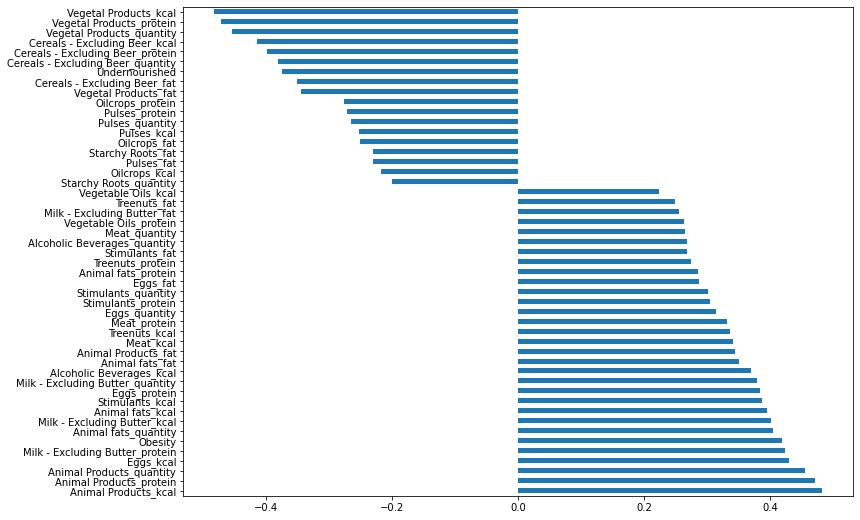

In [58]:
plt.figure(figsize=(12, 9))
golden_features_dict['Confirmed'].plot(kind='barh')

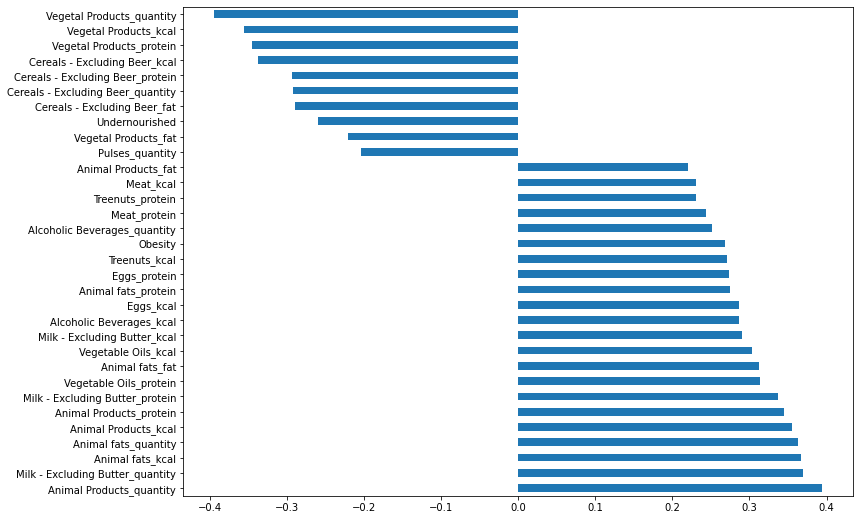

In [59]:
plt.figure(figsize=(12, 9))
golden_features_dict['Deaths'].plot(kind='barh')

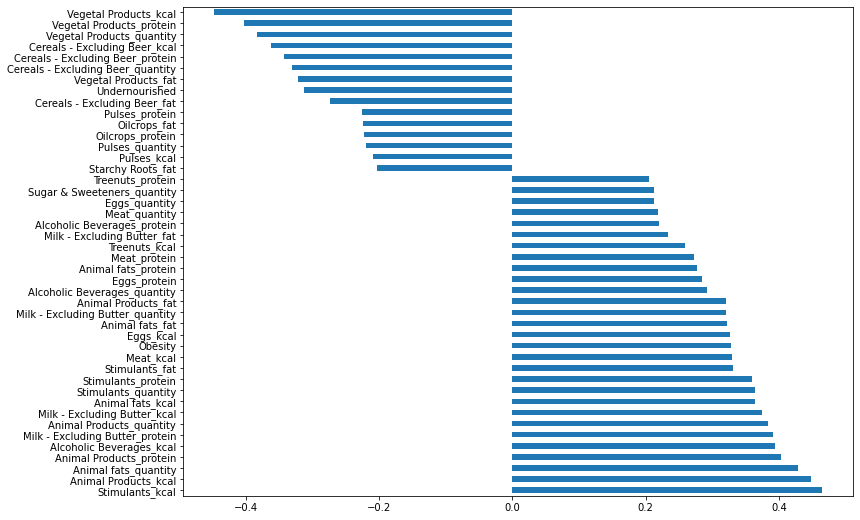

In [60]:
plt.figure(figsize=(12, 9))
golden_features_dict['Recovered'].plot(kind='barh')

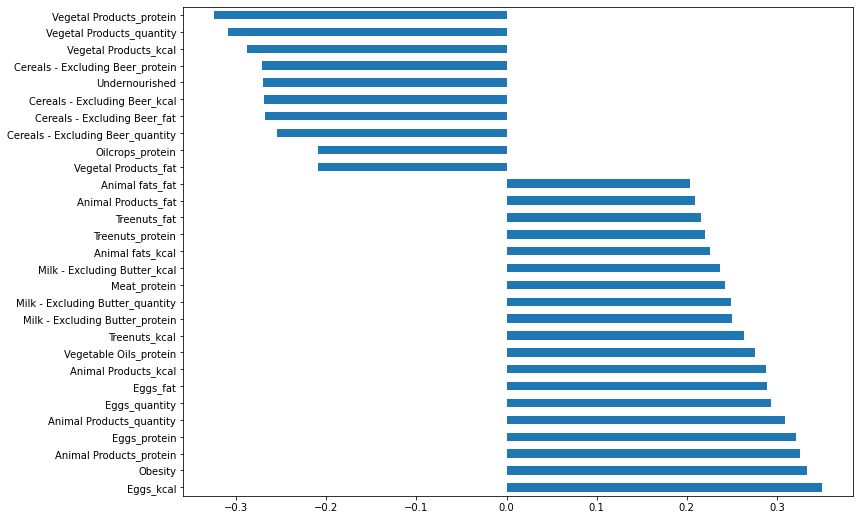

In [61]:
plt.figure(figsize=(12, 9))
golden_features_dict['Active'].plot(kind='barh')

## Remover outliers

In [62]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.000001)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

1 outliers detectados


## Separando features das targets

In [63]:
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [64]:
cols = dataset.columns.to_list()

In [65]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [66]:
x_features.head()

,Country,Obesity,Undernourished,Population,Unit (all except Population),Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,...,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity,is outlier
0,Afghanistan,4.5,29.800000,38042000.0,%,0.0,21.6397,6.2224,0.0,8.0353,...,0.0574,0.8802,0.3078,0.0,1.3489,0.0770,40.5645,0.5345,6.7642,0
1,Albania,22.3,6.200000,2858000.0,%,0.0,32.0002,3.4172,0.0,2.6734,...,0.0008,1.8096,0.1055,0.0,1.5367,0.1515,31.2304,0.3261,11.7753,0
2,Algeria,26.6,3.900000,43406000.0,%,0.0,14.4175,0.8972,0.0,4.2035,...,0.0557,4.1340,0.2216,0.0,1.8342,0.1152,40.3651,1.0310,11.6484,0
3,Angola,6.8,25.000000,31427000.0,%,0.0,15.3041,1.3130,0.0,6.5545,...,0.0009,18.1102,0.0508,0.0,1.8495,0.0061,45.0722,0.6463,2.3041,0
4,Antigua and Barbuda,19.1,11.258442,97000.0,%,0.0,27.7033,4.6686,0.0,3.2153,...,0.1524,1.4522,0.1564,0.0,3.8749,0.0253,33.3233,0.8102,5.4495,0


In [67]:
del x_features['Unit (all except Population)']

In [68]:
del x_features['is outlier']

In [69]:
x_features.dtypes.value_counts()

float64    95
object      1
dtype: int64

In [70]:
x_features_orig = x_features.copy()

In [71]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

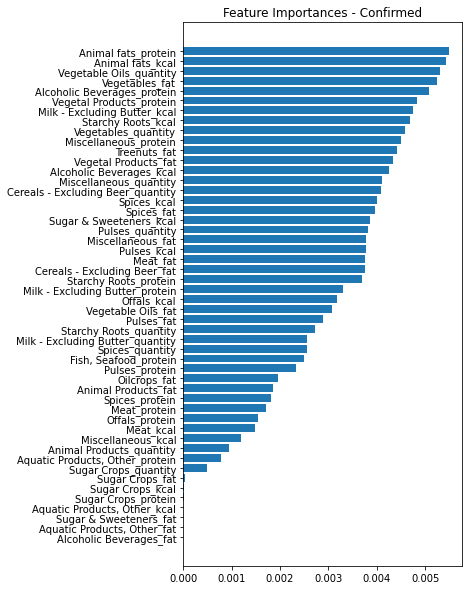

<Figure size 432x288 with 0 Axes>

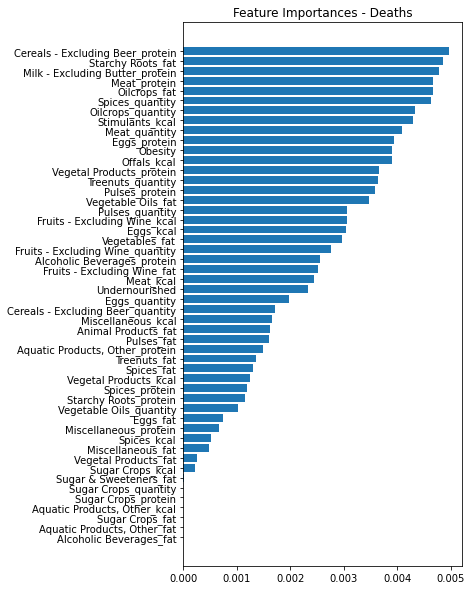

<Figure size 432x288 with 0 Axes>

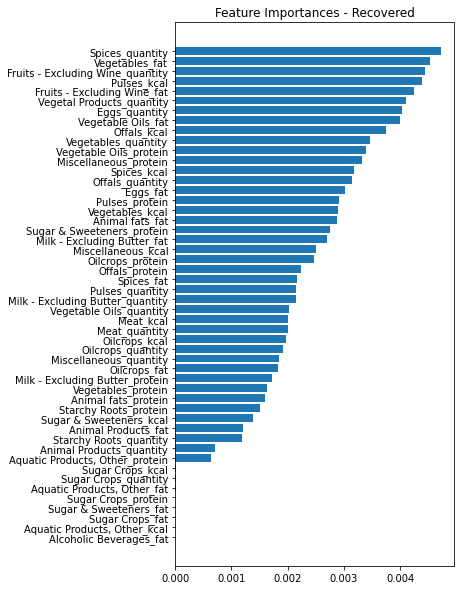

<Figure size 432x288 with 0 Axes>

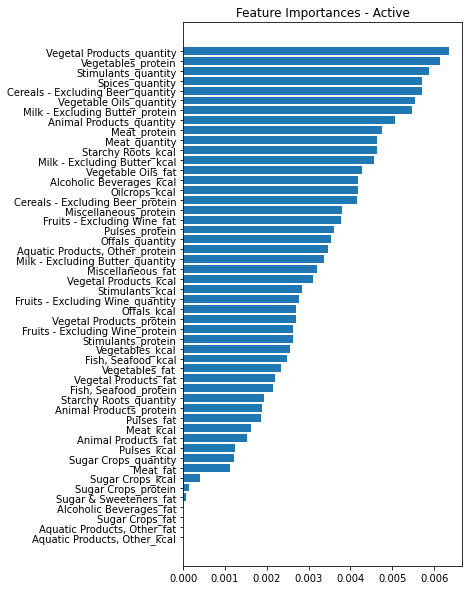

In [72]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

<Figure size 432x288 with 0 Axes>

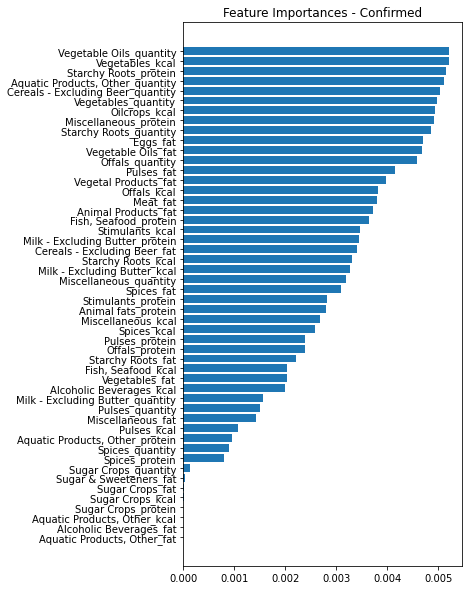

Vegetable Oils_quantity 0.005204738191705547
Vegetables_kcal 0.005196704035303216
Starchy Roots_protein 0.005152485027555889
Aquatic Products, Other_quantity 0.005107694354484649
Cereals - Excluding Beer_quantity 0.0050398267662858645
Vegetables_quantity 0.004978194539430381
Oilcrops_kcal 0.004928519437742082
Miscellaneous_protein 0.004913589633725146
Starchy Roots_quantity 0.0048588887686477865
Eggs_fat 0.004688491152420719
Vegetable Oils_fat 0.004671821578749528
Offals_quantity 0.004579117061429364
Pulses_fat 0.004155951123203992
Vegetal Products_fat 0.003971671273421518
Offals_kcal 0.0038172191523070482
Meat_fat 0.0037959160951017345
Animal Products_fat 0.0037230023624484354
Fish, Seafood_protein 0.0036299109497805824
Stimulants_kcal 0.0034694211099737782
Milk - Excluding Butter_protein 0.0034400376746147932
Cereals - Excluding Beer_fat 0.0034076957227994514
Starchy Roots_kcal 0.0033022116939637304
Milk - Excluding Butter_kcal 0.003258638857729666
Miscellaneous_quantity 0.0031956823

<Figure size 432x288 with 0 Axes>

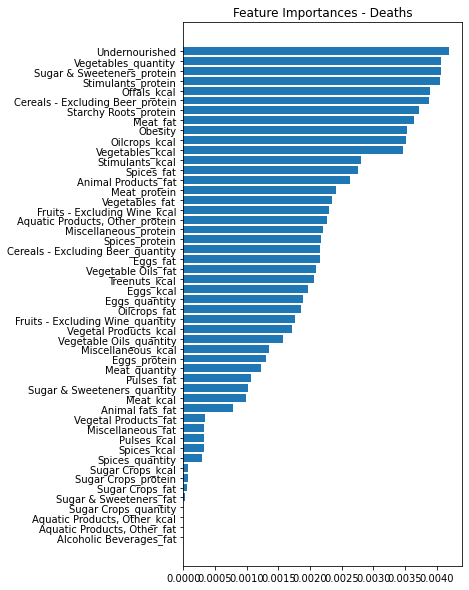

Undernourished 0.004192323083485786
Vegetables_quantity 0.004067367910082889
Sugar & Sweeteners_protein 0.004065406259703613
Stimulants_protein 0.0040589387868702935
Offals_kcal 0.003886611951611387
Cereals - Excluding Beer_protein 0.0038746004909019165
Starchy Roots_protein 0.0037193541069596835
Meat_fat 0.0036366914162535807
Obesity 0.0035388148192695107
Oilcrops_kcal 0.003519945104008805
Vegetables_kcal 0.003463283712195388
Stimulants_kcal 0.0028035923081436258
Spices_fat 0.002762627624135965
Animal Products_fat 0.002635366830081422
Meat_protein 0.0024152146572168575
Vegetables_fat 0.00234617238170458
Fruits - Excluding Wine_kcal 0.00230316149916698
Aquatic Products, Other_protein 0.0022689438740651443
Miscellaneous_protein 0.0022045430365496797
Spices_protein 0.002177138830031686
Cereals - Excluding Beer_quantity 0.002156600993652927
Eggs_fat 0.002153040315519226
Vegetable Oils_fat 0.002087503336893671
Treenuts_kcal 0.0020585755419044397
Eggs_kcal 0.00197204342264995
Eggs_quantity 

<Figure size 432x288 with 0 Axes>

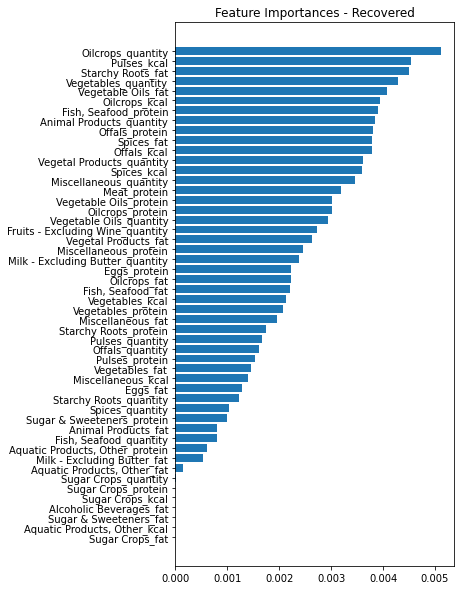

Oilcrops_quantity 0.005113138876644203
Pulses_kcal 0.00454141065374773
Starchy Roots_fat 0.004491980989093017
Vegetables_quantity 0.004281065538729861
Vegetable Oils_fat 0.0040838091956028385
Oilcrops_kcal 0.003945946663593626
Fish, Seafood_protein 0.003906669380059317
Animal Products_quantity 0.0038356589675486536
Offals_protein 0.003800098918051359
Spices_fat 0.003789606277655454
Offals_kcal 0.0037823287128079443
Vegetal Products_quantity 0.0036086505942502928
Spices_kcal 0.0035856789784716615
Miscellaneous_quantity 0.0034602613773357885
Meat_protein 0.003194518962623814
Vegetable Oils_protein 0.0030258161102819513
Oilcrops_protein 0.0030194881084966443
Vegetable Oils_quantity 0.002943254924353939
Fruits - Excluding Wine_quantity 0.0027333377833010904
Vegetal Products_fat 0.002630502996210504
Miscellaneous_protein 0.002457200616963058
Milk - Excluding Butter_quantity 0.0023754180921912145
Eggs_protein 0.0022309442687737657
Oilcrops_fat 0.002223510511055366
Fish, Seafood_fat 0.0022149

<Figure size 432x288 with 0 Axes>

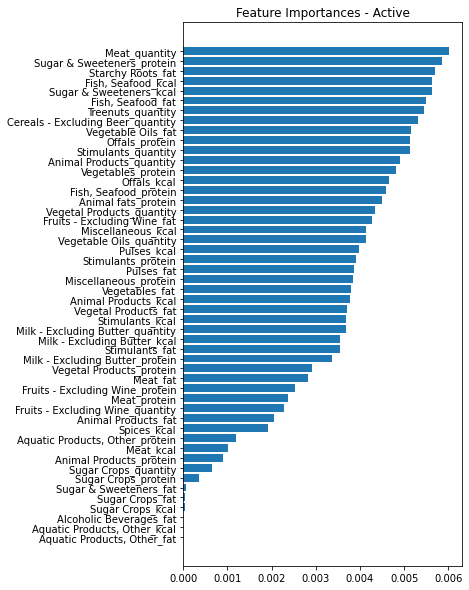

Meat_quantity 0.0060120647456596565
Sugar & Sweeteners_protein 0.005863545174354216
Starchy Roots_fat 0.005692022474574023
Fish, Seafood_kcal 0.005623674656526462
Sugar & Sweeteners_kcal 0.005619697822640082
Fish, Seafood_fat 0.005496621033972757
Treenuts_quantity 0.0054519440422341695
Cereals - Excluding Beer_quantity 0.005309727550505249
Vegetable Oils_fat 0.005159536413577768
Offals_protein 0.005127517789281171
Stimulants_quantity 0.0051221462376175204
Animal Products_quantity 0.004896506463918194
Vegetables_protein 0.004814556015531601
Offals_kcal 0.004667111868841372
Fish, Seafood_protein 0.004593571144309004
Animal fats_protein 0.004497216202707574
Vegetal Products_quantity 0.004333836067649006
Fruits - Excluding Wine_fat 0.004260606677798028
Miscellaneous_kcal 0.004146403151525277
Vegetable Oils_quantity 0.004134783816651139
Pulses_kcal 0.003984883496106708
Stimulants_protein 0.003905780964215455
Pulses_fat 0.0038732587027630384
Miscellaneous_protein 0.003846925438098329
Vegetab

In [73]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.99, quantidade=99)


In [74]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Confirmed 26
Deaths 29
Recovered 25
Active 29


<Figure size 432x288 with 0 Axes>

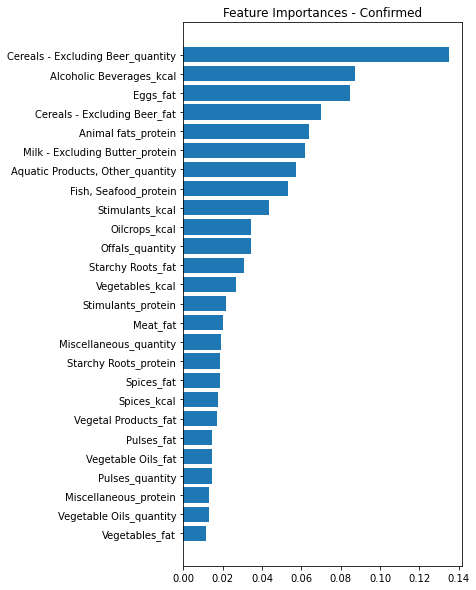

<Figure size 432x288 with 0 Axes>

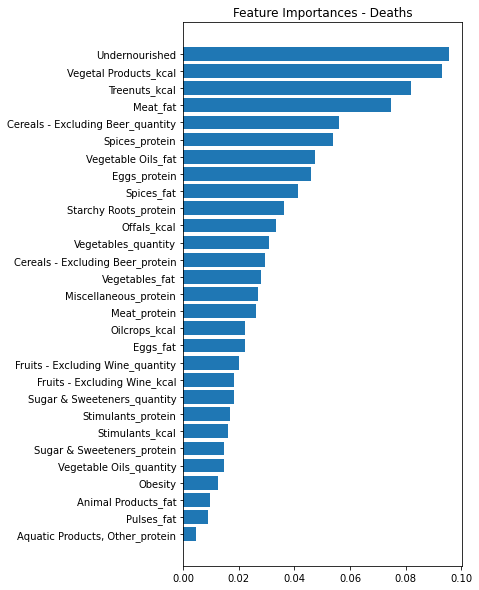

<Figure size 432x288 with 0 Axes>

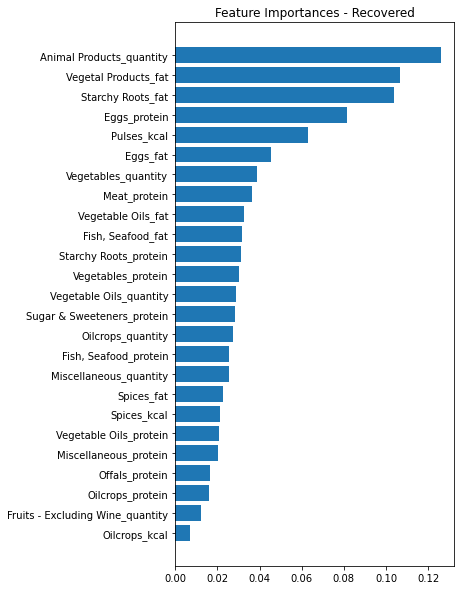

<Figure size 432x288 with 0 Axes>

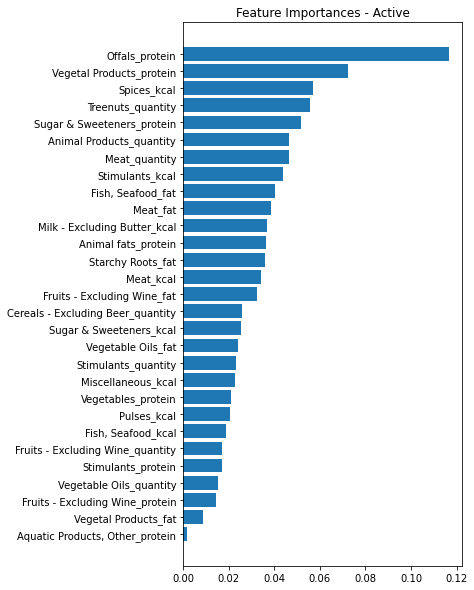

In [75]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

In [76]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

x_train_dict_sens = {}
y_train_dict_sens = {}
x_test_dict_sens = {}
y_test_dict_sens = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.01, random_state=42)
    x_train_dict_sens[t], x_test_dict_sens[t], y_train_dict_sens[t], y_test_dict_sens[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.5, random_state=42)
    print (y_train_dict[t].shape, y_test_dict[t].shape)

(158,) (2,)
(158,) (2,)
(158,) (2,)
(158,) (2,)


## Pré processamento

In [77]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    _, scaler_sens = normalizar_numericas(x_train_dict_sens[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])
    x_test_dict_sens[t][colunas_a_normalizar[t]] = scaler_sens.transform(x_test_dict_sens[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    x_train_dict_sens[t], enc_sens = codificar_categoricas(x_train_dict_sens[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)
    
    test_categ_sens = pd.DataFrame(enc_sens.transform(x_test_dict_sens[t][colunas_a_codificar[t]]).toarray())
    x_test_dict_sens[t].reset_index(inplace=True, drop=True)
    x_test_dict_sens[t] = pd.concat([test_categ_sens, x_test_dict_sens[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

## Análise de sensibilidade

In [78]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

metricas = {'mse': mse_scorer,
            'mae': mae_scorer
           }

errors = [mean_squared_error, mean_absolute_error]

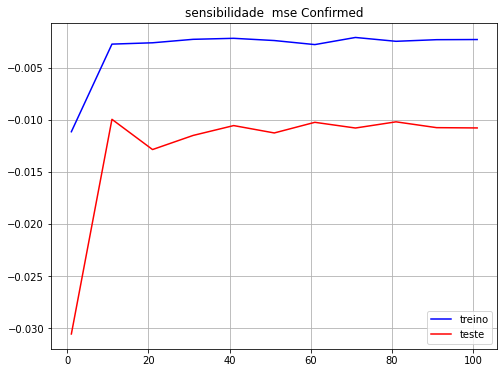

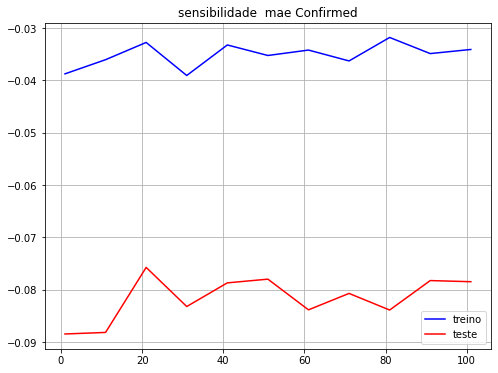

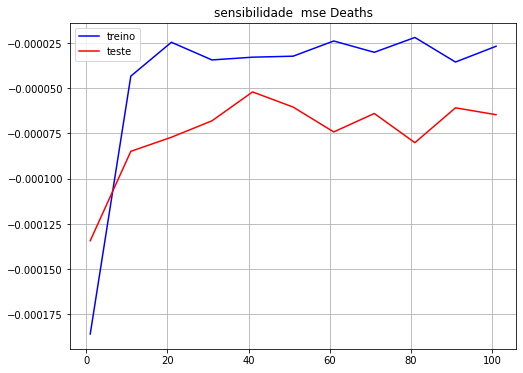

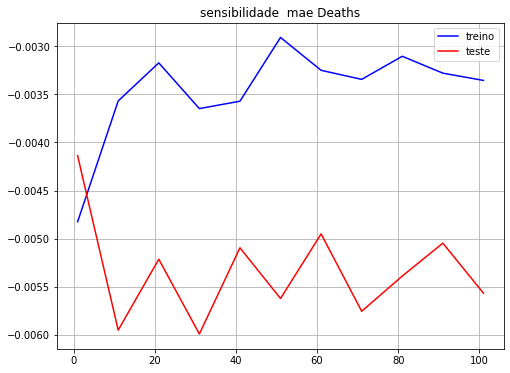

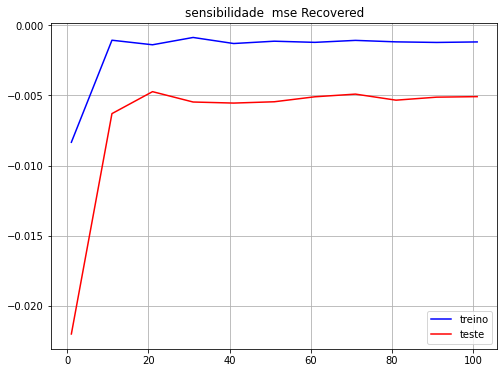

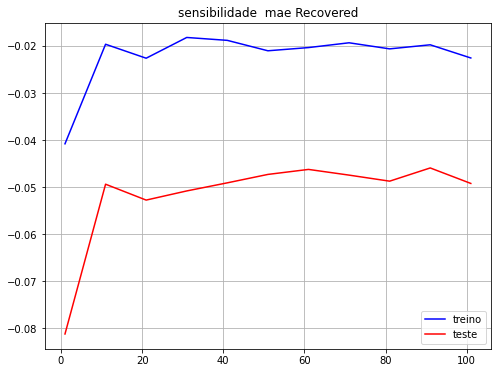

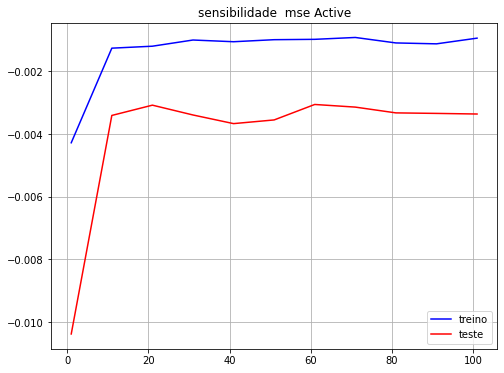

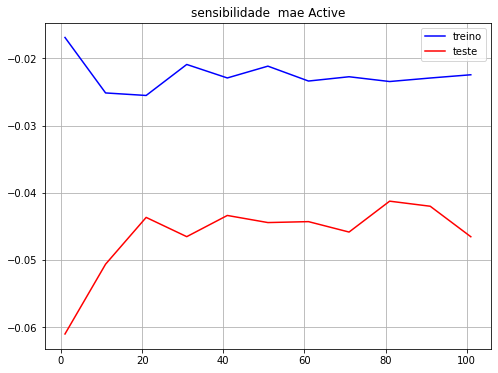

In [79]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = BaggingRegressor(base_estimator=ExtraTreeRegressor(), 
                                     n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

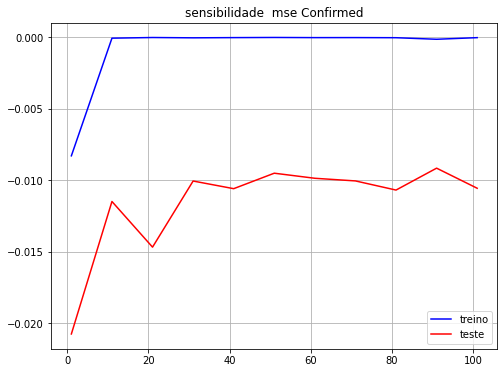

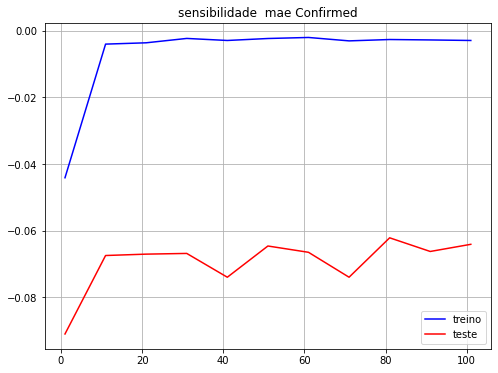

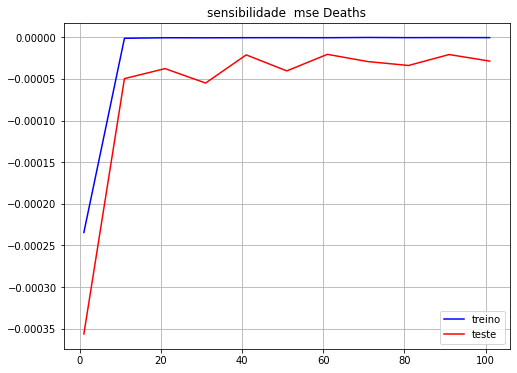

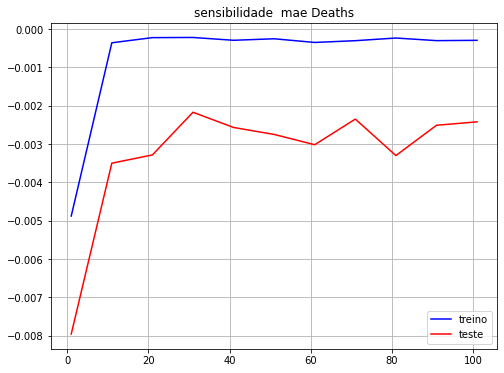

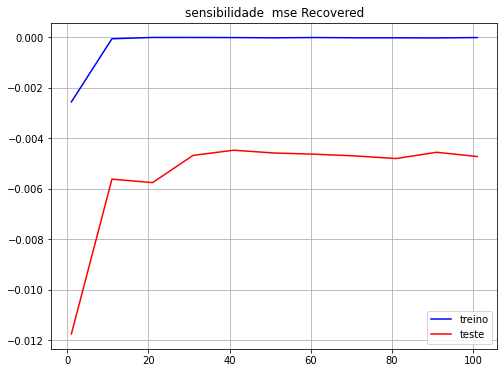

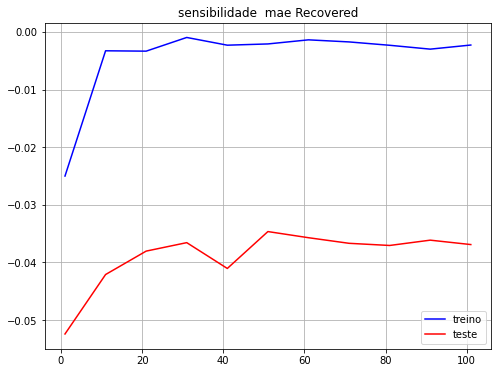

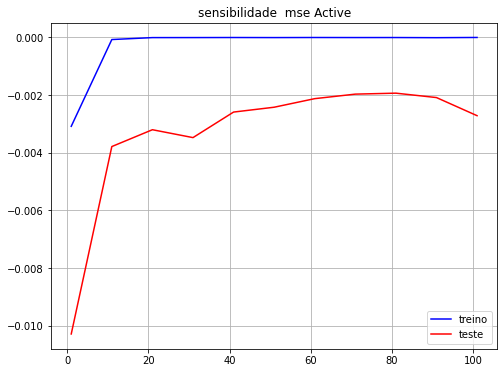

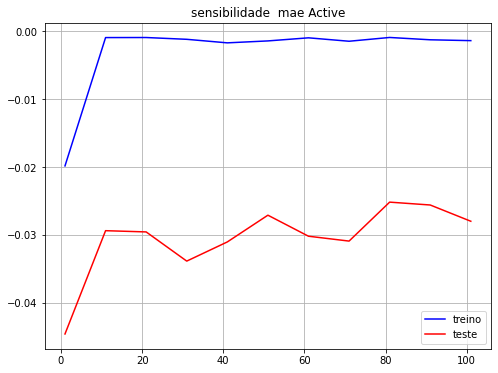

In [80]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = AdaBoostRegressor(base_estimator=ExtraTreeRegressor(), 
                                      n_estimators=n_arvores)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

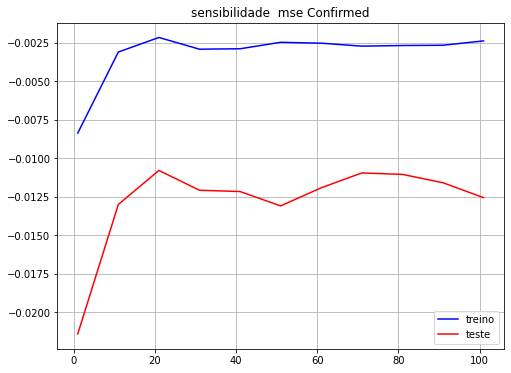

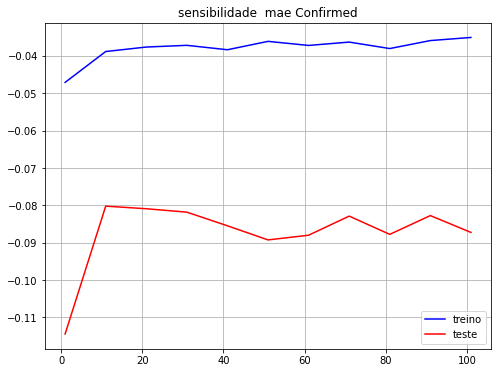

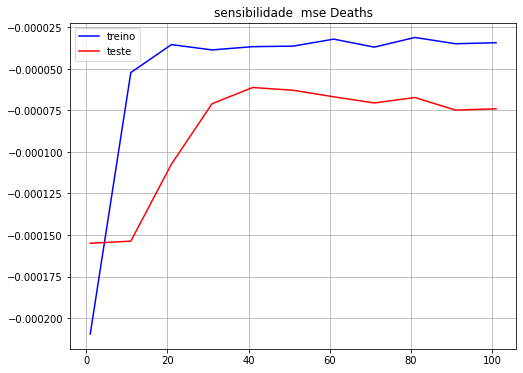

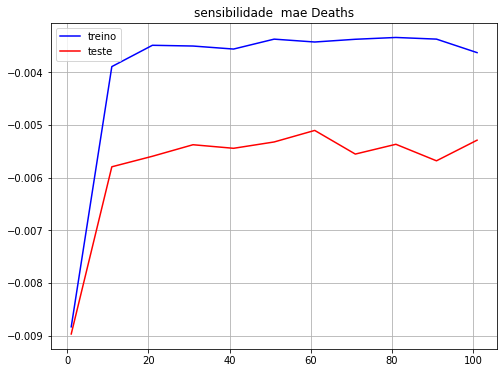

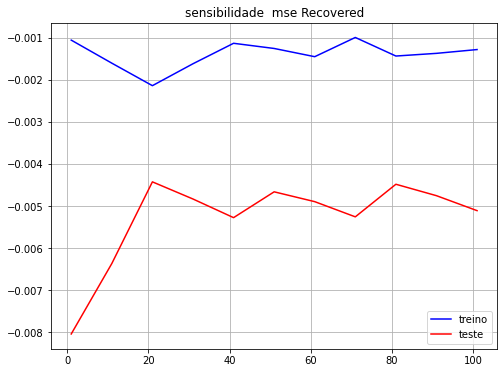

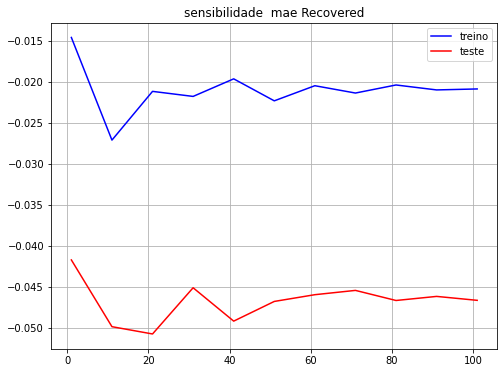

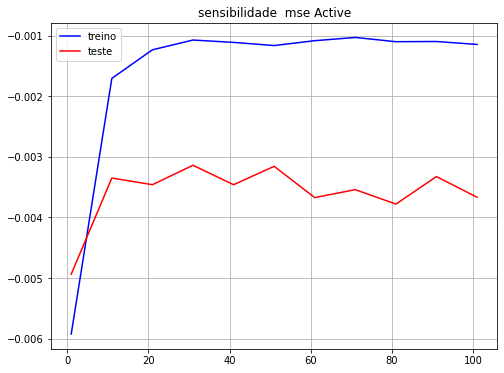

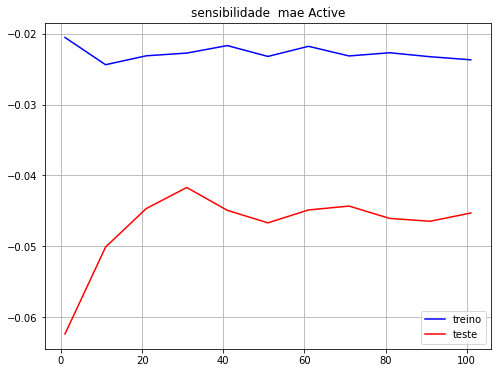

In [81]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = RandomForestRegressor(n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

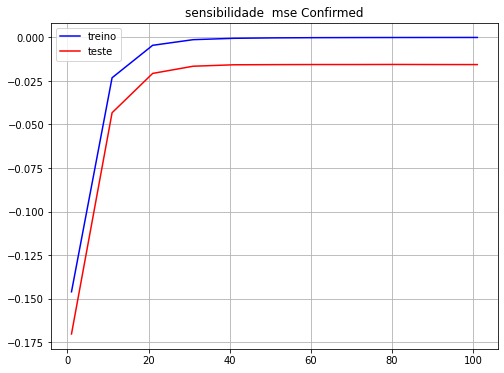

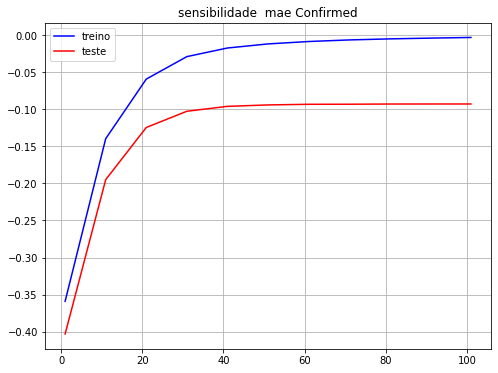

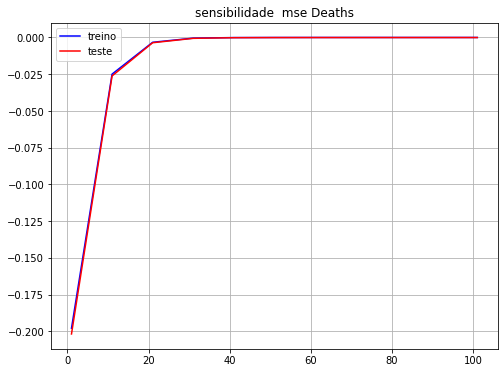

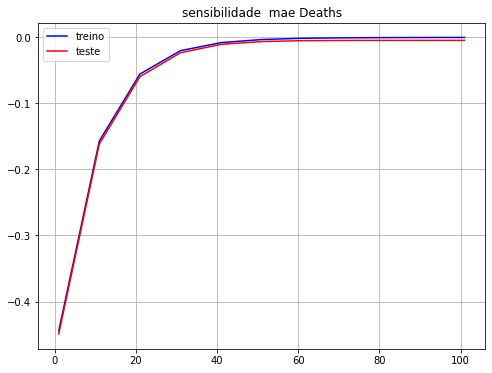

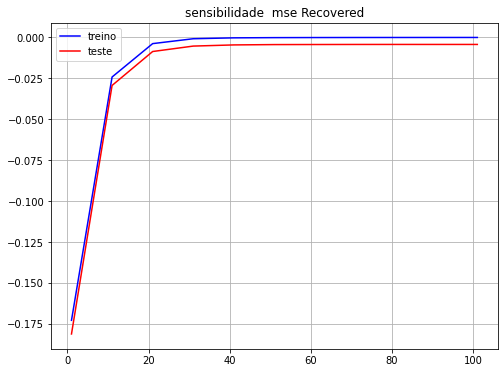

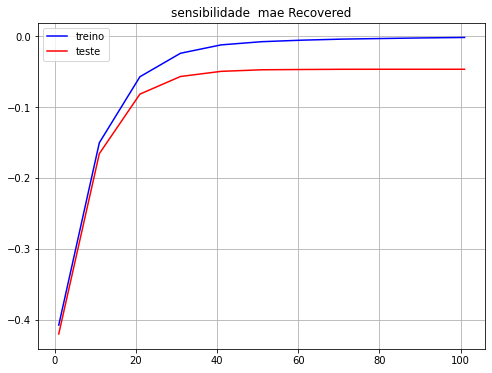

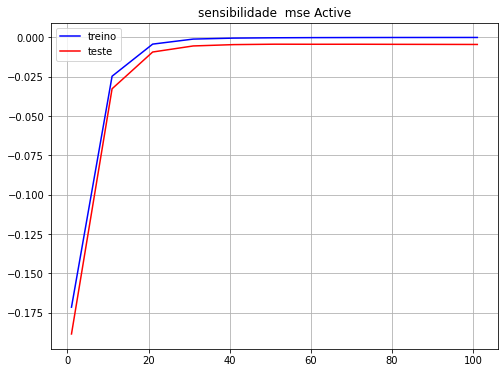

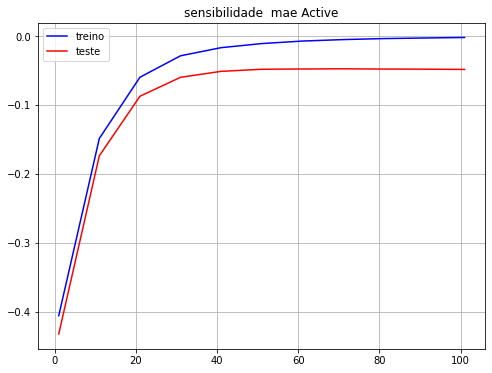

In [82]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = xgb.XGBRegressor(n_estimators=n_arvores,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

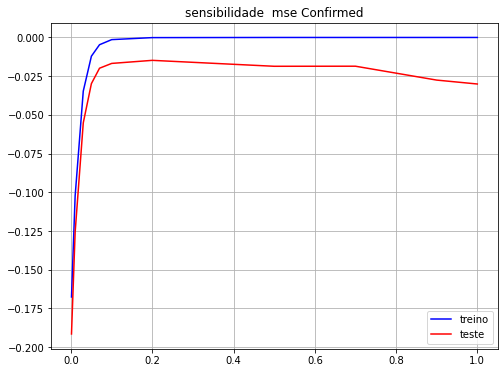

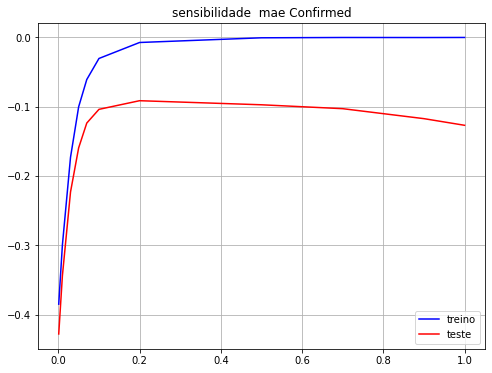

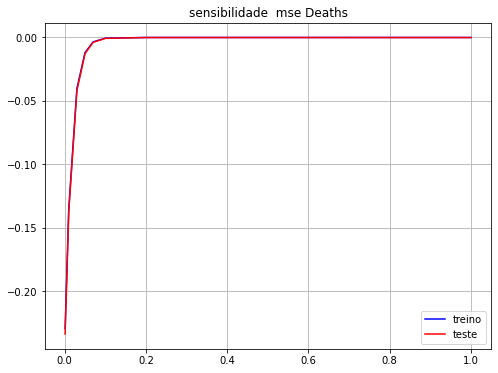

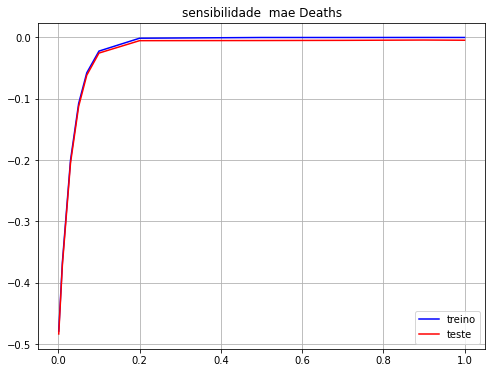

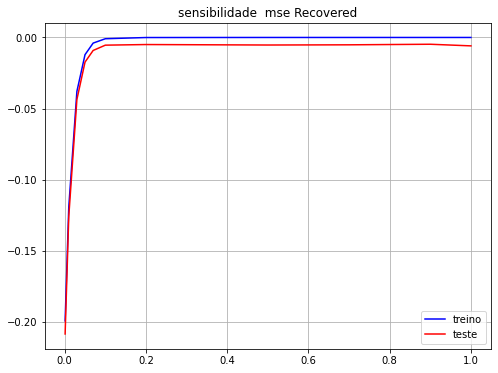

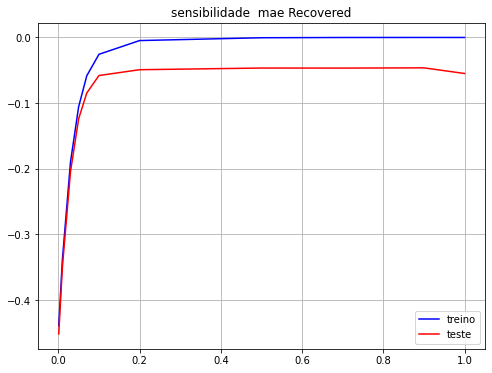

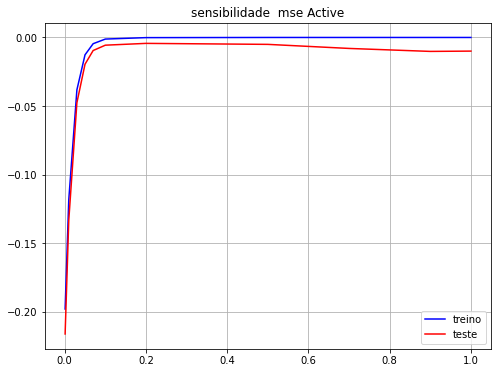

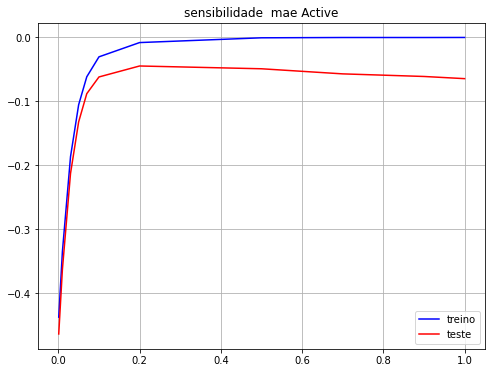

In [83]:
lista_learning_rate = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 0.9, 1.]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for lr in lista_learning_rate:
            model = xgb.XGBRegressor(n_estimators=30,
                                     learning_rate=lr,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_learning_rate, train_results, 'b', label="treino")
        plt.plot(lista_learning_rate, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

## Model selection: otimização

In [84]:
modelos_dict = {'ridge': Ridge(),
                'lasso': Lasso(),
                'bagging': BaggingRegressor(),
                'adaboost': AdaBoostRegressor(),
                'random forest': RandomForestRegressor(),
                'gradient boosting':xgb.XGBRegressor(),
                }

ridge_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

lasso_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

bagging_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()], 
                      'n_estimators': [10, 20, 30, 40, 50], 
                      'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'bootstrap': [True], 
                      'bootstrap_features': [False, True],
                      'n_jobs': [-1]
                     }

adaboost_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()],
                       'n_estimators': [10, 20, 30, 40, 50], 
                       'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                       'loss': ['linear', 'square', 'exponential']
                      }

rf_param_grid = {'n_estimators': [10, 20, 30, 40, 50],
                 'max_features': np.arange(1, 20, 1),
                 'max_depth':np.arange(1, 20, 1),
                 'min_samples_split': np.arange(2, 20, 1),
                 "bootstrap": [True, False],
                 'n_jobs': [-1]
                 }

gdbt_param_grid = {'max_depth': np.arange(3, 20, 1),
                   'learning_rate': stats.uniform(loc=0.1, scale=0.3),
                   'n_estimators': [10, 20, 30, 40, 50],
                   'n_jobs': [-1],
                   'gamma': stats.uniform(loc=0.001, scale=10),
                   'subsample': stats.uniform(loc=0.1, scale=0.9),
                   'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
                   'reg_alpha': stats.uniform(loc=0.001, scale=10),
                   'reg_lambda': stats.uniform(loc=0.01, scale=5),
                   'booster': ['gbtree', 'gblinear', 'dart'],
                   'objective': ['reg:squarederror']
                   }


param_dict = {'ridge':ridge_param_grid,
              'lasso': lasso_param_grid,
              'bagging': bagging_param_grid,
              'adaboost': adaboost_param_grid,
              'random forest': rf_param_grid,
              'gradient boosting':gdbt_param_grid,
             }

In [85]:
n_iteracoes = 10

In [86]:
%%time

resultados_dict = {}
otm_time_dict = {}
melhor_modelo_dict = {}
melhor_modelo_nome = {}
melhores_parametros_dict = {}
best_score = {}
resultados = {}

n_folds = 10

loo = LeaveOneOut()

for t in targets:
    _, _, _, resultados[t], _ = busca_aleatoria(x_train_dict[t], y_train_dict[t], Ridge(), param_dict['ridge'], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
    resultados[t]['nome'] = 'ridge'

for t in targets:
    best_score[t] = -9999.
    melhor_modelo_nome[t] = None
    melhor_modelo_dict[t] = None
    melhores_parametros_dict[t] = None
    for nome, modelo in modelos_dict.items():
        print (nome)
        melhor_modelo, melhores_parametros, score, result, otm_time = busca_aleatoria(x_train_dict[t], y_train_dict[t], modelo, param_dict[nome], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
        result['nome'] = nome
        resultados[t] = pd.concat([resultados[t], result])
        if score > best_score[t]:
            melhor_modelo_nome[t] = nome
            melhor_modelo_dict[t] = melhor_modelo
            melhores_parametros_dict[t] = melhores_parametros
            best_score[t] = score



 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
random forest

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
gradient boosting

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâ

In [87]:
for t in targets:
    print (resultados[t].shape)
    resultados[t].sort_values(by='mean_test_'+list(metricas.keys())[0], inplace=True, ascending=False)

(70, 348)
(70, 348)
(70, 348)
(70, 348)


In [88]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, t, resultados[t]['mean_test_'+list(metricas.keys())[i]].max())

mse Confirmed -0.01236148894929996
mae Confirmed -0.06668286859941495
mse Deaths -0.00010612313839870122
mae Deaths -0.003929582153506535
mse Recovered -0.006061042964106378
mae Recovered -0.03602604758452762
mse Active -0.004346808423812271
mae Active -0.034366928366753494


In [89]:
for t in targets:
    print (t, best_score[t])

Confirmed -0.01236148894929996
Deaths -0.00010612313839870122
Recovered -0.006061042964106378
Active -0.004346808423812271


In [90]:
resultados['Confirmed'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
2,-0.012361,0.025210,1,-0.080715,0.076463,6,random forest
7,-0.012813,0.027608,2,-0.079148,0.080921,2,random forest
8,-0.013094,0.028754,3,-0.080589,0.081237,5,random forest
6,-0.013164,0.026744,1,-0.083290,0.078908,5,bagging
4,-0.013250,0.026750,4,-0.083498,0.079232,8,random forest
6,-0.013256,0.026212,5,-0.083849,0.078900,10,random forest
1,-0.013326,0.031733,6,-0.083570,0.079637,9,random forest
2,-0.013355,0.034282,1,-0.066683,0.094382,1,adaboost
4,-0.013379,0.028051,2,-0.081067,0.082508,1,bagging
9,-0.013443,0.028959,7,-0.078514,0.085312,1,random forest


In [91]:
resultados['Deaths'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
7,-0.000106,0.000475,1,-0.004897,0.009063,1,random forest
5,-0.000110,0.000456,2,-0.005181,0.009117,2,random forest
0,-0.000111,0.000484,3,-0.005311,0.009122,3,random forest
9,-0.000111,0.000484,1,-0.005682,0.008899,4,bagging
2,-0.000112,0.000501,1,-0.005540,0.008999,4,ridge
3,-0.000113,0.000508,2,-0.005521,0.009077,3,ridge
8,-0.000114,0.000515,1,-0.005503,0.009164,1,ridge
2,-0.000114,0.000470,2,-0.005977,0.008875,7,bagging
4,-0.000115,0.000491,3,-0.005515,0.009175,2,bagging
7,-0.000115,0.000521,3,-0.005501,0.009227,2,ridge


In [92]:
resultados['Recovered'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
5,-0.006061,0.025789,1,-0.042117,0.065477,1,random forest
0,-0.006064,0.026929,2,-0.042558,0.065213,3,random forest
2,-0.006186,0.027842,3,-0.042542,0.066154,2,random forest
6,-0.006189,0.025730,4,-0.044788,0.064675,7,random forest
1,-0.006200,0.024386,5,-0.044251,0.065129,6,random forest
4,-0.006211,0.027235,6,-0.042885,0.066121,4,random forest
9,-0.006215,0.026517,7,-0.043367,0.065833,5,random forest
7,-0.006300,0.027084,8,-0.045935,0.064727,9,random forest
1,-0.006528,0.025943,1,-0.048166,0.064868,1,bagging
8,-0.006536,0.026874,9,-0.045864,0.066575,8,random forest


In [93]:
resultados['Active'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
0,-0.004347,0.012203,1,-0.043950,0.049145,2,random forest
2,-0.004442,0.012272,2,-0.043314,0.050655,1,random forest
5,-0.004445,0.011487,3,-0.045302,0.048913,6,random forest
1,-0.004460,0.012704,4,-0.044837,0.049490,4,random forest
2,-0.004597,0.013188,1,-0.045249,0.050491,10,ridge
7,-0.004597,0.012741,1,-0.044553,0.051110,1,bagging
4,-0.004600,0.013186,1,-0.045242,0.050527,9,ridge
1,-0.004600,0.013186,2,-0.045241,0.050530,8,ridge
5,-0.004604,0.013185,2,-0.045231,0.050580,9,ridge
9,-0.004612,0.012026,5,-0.045311,0.050589,7,random forest


## Testar modelo

In [94]:
for t in targets:
    modelo = melhor_modelo_dict[t]
    if modelo == None: continue
    modelo.fit(x_train_dict[t], y_train_dict[t])

tabela_compara_dict = {}
train_scores = {}
test_scores = {}
biases = {}
variances = {}

for t in targets:
    modelo = melhor_modelo_dict[t]
    
    tabela_compara_dict[t+' treino'] = []
    tabela_compara_dict[t+' treino baseline'] = []
    
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        if modelo == None: continue
        
        train_scores[t] = metrica(modelo, x_train_dict[t], y_train_dict[t]) 
        test_scores[t] = metrica(modelo, x_test_dict[t], y_test_dict[t])
        
        baseline_train = errors[i](y_train_dict[t], np.ones((y_train_dict[t].shape)) * y_train_dict[t].mean())
        baseline_test = errors[i](y_test_dict[t], np.ones((y_test_dict[t].shape)) * y_train_dict[t].mean())
        
        print ( met_nome + ": score de treino " + str(-metrica(modelo, x_train_dict[t], y_train_dict[t]).round(4)) + " e score de teste: " + str(-metrica(modelo, x_test_dict[t], y_test_dict[t]).round(4)) + " para target: " + str(t))
        print ( met_nome + ": baseline treino " + str(baseline_train.round(4)) + " baseline teste: " + str(baseline_test.round(4)) + " para target: " + str(t))
        
        tabela_compara_dict[t+' treino baseline'].append(baseline_train)
        tabela_compara_dict[t+' treino'].append(-metrica(modelo, x_train_dict[t], y_train_dict[t]))
        

mse: score de treino 0.0058 e score de teste: 0.0024 para target: Confirmed
mse: baseline treino 0.0164 baseline teste: 0.0033 para target: Confirmed
mae: score de treino 0.0528 e score de teste: 0.0375 para target: Confirmed
mae: baseline treino 0.0956 baseline teste: 0.0428 para target: Confirmed
mse: score de treino 0.0 e score de teste: 0.0 para target: Deaths
mse: baseline treino 0.0001 baseline teste: 0.0 para target: Deaths
mae: score de treino 0.003 e score de teste: 0.0019 para target: Deaths
mae: baseline treino 0.006 baseline teste: 0.0025 para target: Deaths
mse: score de treino 0.0016 e score de teste: 0.0025 para target: Recovered
mse: baseline treino 0.0073 baseline teste: 0.0011 para target: Recovered
mae: score de treino 0.0161 e score de teste: 0.0493 para target: Recovered
mae: baseline treino 0.0512 baseline teste: 0.0314 para target: Recovered
mse: score de treino 0.0031 e score de teste: 0.0003 para target: Active
mse: baseline treino 0.0046 baseline teste: 0.0008

In [95]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, 'leave one out treino', t, resultados[t]['mean_test_'+list(metricas.keys())[i]].min())

mse leave one out treino Confirmed -0.04267017889971288
mae leave one out treino Confirmed -0.18880140594012992
mse leave one out treino Deaths -0.04348582852278731
mae leave one out treino Deaths -0.20820627914173828
mse leave one out treino Recovered -0.109254773638668
mae leave one out treino Recovered -0.3247407767609804
mse leave one out treino Active -0.027607247662652712
mae leave one out treino Active -0.15970138855771202


In [96]:
tabela_compara = pd.DataFrame.from_dict(tabela_compara_dict, orient='index', columns=['MSE', 'MAE'])

In [97]:
tabela_compara

,MSE,MAE
Confirmed treino,0.005831,0.052812
Confirmed treino baseline,0.016403,0.095625
Deaths treino,0.000038,0.002969
Deaths treino baseline,0.000134,0.006047
Recovered treino,0.001612,0.016092
Recovered treino baseline,0.007324,0.051161
Active treino,0.003140,0.037034
Active treino baseline,0.004572,0.045398
